# Creating a training database for dolphin clicks by importing Pamguard CSV annotation files
(CLICKLEARN DSTI Project)


The objective of this notebook is to complete and adapt Ketos *Creating Database (Extended)* notebook (
https://docs.meridian.cs.dal.ca/ketos/tutorials/create_database/index.html) for **Pamguard software** users.
Pamguard is an open source software which objective is to provide free and easy to handle tools for cetacean passive acoustic monitoring (PAM): https://www.pamguard.org/.

All the content of this notebook (Chapters 1 to 8) replaces the original one :

* Chapters 1 to 2 complete original chapter 2, by providing methods to load a CSV file exported by **Pamguard software**, and convert it as Ketos annotation table, dealing with datetime and timedelta operations. The original notebook described methods to import CSV files which already match to the Ketos requirements, but not to import and convert other CSV files.
* Chapter 3 provides a method to put every WAV file in a unique folder, as required by Ketos before automatically building a database.
* Chapter 4 to 8 is specific to ClickLearn project. They follow the same structure as in the original notebook but adapt all the settings for dolphin clicks detection. 


Two types of CSV file exported by Pamguard can be used with these methods. One section of this notebook will be dedicated to each type :

* **Events annotation CSV files**: quoting start and end of time ranges (several seconds long) in which clicks streams have been identified.
* **Clicks annotation CSV files**: quoting start time of identified clicks. Click duration is about few milliseconds and has to be set in parameters (see below).

The converted annotation tables will then be ready to be directly used by Ketos library (see Chapter 4 and followings). **For a first training, only the Events annotation CSV files will be used to train the model.**

Steps 1 to 4 of this notebook are illustrated in the following figure:

<br><br>
<img src="img/building_database_notebook_steps.jpg" alt="building database steps" style="width: 70%;"/>



## Contents:

[1. Imports and settings](#section1)  
[2a. Building annotation files from Events Annotations CSV files](#section2a)  
[2b. Building annotation files from Clicks Annotations CSV files](#section2b)  
[3. Grouping all .WAV files in a same folder](#section3)  
[4. Standardize Ketos annotation tables](#section4)  
[5. Creating segments of uniform length and augmenting the data](#section5)  
[6. Including background noise](#section6)  
[7. Choosing the spectrogram settings](#section7)  
[8. Creating the database](#section8)  




<a id="section1"></a>
## 1. Imports and settings

### Importing the packages

We will use several modules within ketos and also the pandas package



In [1]:
import os
import numpy as np
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.audio.spectrogram import MagSpectrogram
from ketos.data_handling.parsing import load_audio_representation

from datetime import datetime
from typing import Union
import math
import random

# This last package is made by ClickLearn DSTI team to extract informations from a Pamguard CSV export file 
# and buid a Ketos annotation table (Pandas dataframe)
# import ketos_annotation_table as kat

C:\Users\groul\anaconda3\envs\ketos_env\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Import functions



<span style = "color : red;">
TODO:
    
* Move following methods in Ketos_annotation_table.py when finished, then delete this chapter
</span>


In [2]:
def list_pamguard_wav_files(wav_files_path):
    """Lists every wav files contained in a directory tree. The structuure of file names is specific to pamguard.
        Args:
            filename : str
                PAMGUARD .wav or audio_file name. 
                It must end with the following structure before ".wav": YYYYmmdd_HHMMSS_f
                example: 048_20180528_003358_587.wav  
        Returns:
            Pandas Dataframe
                DataFrame with 2 columns:
                    filestart: absolute UTC datetime value at which the wav file record starts
                    filename: name of the wav file
    """
    file_list = []
    for root, directory, files in os.walk(wav_files_path):
        for file in files:
            if file.endswith('wav'):
                file_list.append([datetime.strptime(file[-23:-4], '%Y%m%d_%H%M%S_%f'), file])

    file_list.sort()
    return pd.DataFrame(file_list, columns = ['filestart', 'filename'])

In [3]:
def pamguard_events_annotations_csv_to_df(annotation_csv_path:str, wav_files_dataframe, events_subsampling_option:int = 2):
    """Convert a Pamguard CSV annotation file into a Ketos annotation table (non standardized). 
        Args:
            annotation_csv_path: str
                complete path of the annotation CSV file. CSV separator must be ','
            wav_files_dataframe: Pandas DataFrame
                DataFrame listing all WAV files that annotation CSV file refer to. 
                This DataFrame has only 2 columns: 
                    filename:str
                        name of the wav file
                    filestart: datetime
                        absolute UTC time at which the wav file starts
            events_subsampling_option: int
                Subsampling is optional but highly recommended to avoid unsure detections. 
                From the less to the most selective option:
                - 0: no subsampling. All detections (sure, unsure...) are kept
                - 1: subsample excluding all commented detections in 'comment' column 
                    (comments always refer to unsure detections), 
                    then including 'definite' ('DLD') and 'probable' ('DLP') dolphin click detections as well
                - 2 (default value): subsample excluding all commented detections in 'comment' column 
                    (comments always refer to unsure detections), 
                    then including only 'definite' dolphin click detections ('DLD')
               
        Returns:
            annotations_df: pd.DataFrame
                Ketos annotation table (non standardized)
    """

    # import CSV in a dataframe
    annotations_df = pd.read_csv(annotation_csv_path, sep=",")

    # Remove all whitespaces from string typed series of the dataframe 
    annotations_df = strip_dataframe(annotations_df)

    # SUBSAMPLING (SPECIFIC TO EVENT ANNOTATION DF, with option 2 > 1 > 0, check docstring):
    if events_subsampling_option == 2:
        annotations_df = annotations_df.loc[((annotations_df.comment.isna()) 
                                             & (annotations_df.eventType == 'DLD') | (annotations_df.eventType == 'other')),]
    if events_subsampling_option == 1:
        annotations_df = annotations_df.loc[(annotations_df.comment.isna()),]    

    # updating pd.Series type from string to datetime
    annotations_df = annotations_df.rename(columns = {'UTC':'start', 'EventEnd':'end', 'eventType':'label'})
    annotations_df.start = pd.to_datetime(annotations_df.start, format = '%Y-%m-%d %H:%M:%S.%f')
    annotations_df.end = pd.to_datetime(annotations_df.end, format = '%Y-%m-%d %H:%M:%S.%f')


    # computing start and end time from beginning of the file
    # + creating a new column to add .wav filenames
    annotations_df['filename']=""
    annotations_df = annotations_df.reset_index()
    for index, row in annotations_df.iterrows():
        try:
            #select all the files that starts before or at the same time than "start", pick the last of them  
            matching_loc = wav_files_dataframe.loc[(wav_files_dataframe.filestart <= row.start)].iloc[-1]
            annotations_df.filename[index] = matching_loc['filename']
            annotations_df.start[index] = (annotations_df.start[index] - matching_loc['filestart'])
            annotations_df.end[index] = (annotations_df.end[index] - matching_loc['filestart'])
        except:
            pass


    #convert 'start' in seconds
#     annotations_df['start'] = pd.Series(annotations_df.start).apply(pd.Timedelta.total_seconds)
#     annotations_df['end'] = pd.Series(annotations_df.end).apply(pd.Timedelta.total_seconds)
    annotations_df['start'] = annotations_df.start.apply(pd.Timedelta.total_seconds)
    annotations_df['end'] = annotations_df.end.apply(pd.Timedelta.total_seconds)
    
    # # select only columns required in Ketos annotation table
    annotations_df = annotations_df.loc[:,('Id', 'start', 'end', 'label', 'filename', 'nClicks', 'comment')]


    # Check start and end values of events annotation df
    check_pamguard_annotation_df(annotations_df)
    
    return annotations_df

In [4]:
def strip_dataframe(df):
    """Removes any white space before and after value of every cells of a dataframe.
        Args:
            df: pd.DataFrame
        Returns:
            df: pd.DataFrame
    """
    for column in df:
        if isinstance(df[column][0], str):
            df[column] = df[column].str.strip()
    return df

In [5]:
def check_pamguard_annotation_df(df):
    """Check Check time validity on annotations from a CSV file extracted from Pamguard software. 
        Uses check_annotation in a loop.
    
        Args:
            df: Pandas DataFrame
                Pamguard annotation DataFrame converted by the pamguard_annotations_csv_to_df() method.
        
        Returns: 
            errors: list
                List of errors containing each incorrect annotation
    """
    errors = []
    for index, row in df.iterrows():
#       row.start : start time of the annotation, in seconds from the beginning of the file
#       row.end : end time of the annotation, in seconds from the beginning of the file
        if row.start > row.end: 
            errors = errors.append(f'Id {index}: end value ({row.end}) is prior to start value ({row.start})')
        # set maximum end time at 3600 seconds, as wav file max duration = 3600 sec 
        if row.end > 3600:
#             next_annot_end = row.end - 3600
            df.end[index] = 3600      
    if errors:
        for error in errors:
            print(error)
    return errors

In [6]:
def subsample_dataframe(df_to_subsample, train_proportion:float):
    """Subsample a Pandas DataFrame into 2 others, based on its indexes.
        
        Args:
            df_to_subsample: pd.DataFrame
            train_proportion: float
                proportion (]0;1[) of indexes to subsample in the dataset, in order to build the train dataset
    
        Returns: tuple with 2 dataframes:
            [0] train subsample 
            [1] test subsamples
    """
    length = len(df_to_subsample)
    nb_train_rows = math.ceil(train_proportion*length)
    #create a sequence corresponding to df indexes to subsample 
    sequence = set(range(length))
    train_indexes = random.sample(sequence, nb_train_rows)
    test_indexes = list(sequence - set(train_indexes))
    return df_to_subsample.iloc[train_indexes], df_to_subsample.iloc[test_indexes]

### Path settings


This part contains all required settings to build annotation dataframes:
* Audio files path (where all audio files are stored)
* File path, where: 
    + CSV fils are stored and Annotation tables **will be** stored
    + Sound files are stored
* Click duration in milliseconds (for Click annotation CSV files)
* Set of valid labels to be used (all labels from CSV file that are not matching this set will be stored in an error log file)

In [7]:
# PATH SETTINGS
# Annotation CSV file folder path (MAC)
# annotations_folder_path ='/Users/benoitmialet/Ketos/ClickLearn/'
# Annotation CSV file folder path (W10)
annotations_folder_path = (r'D:\SYSTEL\Ketos\clicklearn')
# Annotation CSV file name
positive_csv_events_name = 'UBISEA_acoustic_detections_samples_events_positive.csv' 
negative_csv_events_name = 'annotations_events_negative.csv' 
# csv_clicks_name = 'UBISEA_acoustic_detections_samples_clicks.csv'

# Sound file path (MAC)
# sound_files_path = '/Volumes/BENITO/Pelagis - Données acoustiques ASI/Recordings 048 kHz'
# Sound file path (W10)
sound_files_path = r'F:\Pelagis - Données acoustiques ASI\Recordings 048 kHz'

# PATH BUILDING
csv_folder_path = annotations_folder_path
positive_csv_events_path = os.path.join(csv_folder_path,positive_csv_events_name)
negative_csv_events_path = os.path.join(csv_folder_path,negative_csv_events_name)
# csv_clicks_path = os.path.join(csv_folder_path,csv_clicks_name)

# # CLICK ANNOTATION SETTINGS 
# # set click duration (milliseconds) for the dataframe
# clickDuration = pd.Timedelta(2.5, unit = 'milliseconds')
# # set label corresponding to a click detection
# label = 'DLD'

<a id="section2a"></a>
## 2a. Building annotation files from **Events Annotations CSV files** 


This section describes methods to create an annotation table from Pamguard CSV files.

### steps overview:
* Building a wav_df DataFrame with name and start time of every .wav file in sound files folder and sub folders
* Importing a Pamguard CSV file into a Pandas DataFrame:
    + import the CSV file into a dataframe
    + strip blank spaces (strings) in all the dataframe
    + subsample the dataframe regarding the labels (see function details)
    + convert 'start' and 'end' value from string to datetime format
    + add and complete 'filename' column, update 'start' column: for each 'start' value:
        + select rows in wav_df where 'filestart' value <= 'start' value
        + take last index [-1] of this selection 
        + at this index (wav_df), take 'filename' and 'filestart' values
        + copy this 'filename' value in the dataframe, at the right index
        + update 'start' column by computing the time delta in seconds between the dataframe 'start' value and wav_df 'filestart' value
    + convert 'start' and 'end' columns in seconds.


### Building a wav_df dataframe with name and start time of every .wav file in sound files folder and sub folders

For this we use our custom function ```list_wav_files``` that returns a dataframe. This dataframe will be used to find on which .wav file each annotation should be attributed

In [9]:
wav_df = list_pamguard_wav_files(sound_files_path)
wav_df

,filestart,filename
0,2018-05-28 00:29:02.685,048_20180528_002902_685.wav
1,2018-05-28 00:31:22.520,048_20180528_003122_520.wav
2,2018-05-28 00:32:18.970,048_20180528_003218_970.wav
3,2018-05-28 00:33:02.923,048_20180528_003302_923.wav
4,2018-05-28 00:33:58.587,048_20180528_003358_587.wav
...,...,...
4289,2018-09-28 14:00:00.000,048_20180928_140000_000.wav
4290,2018-09-28 15:00:00.001,048_20180928_150000_001.wav
4291,2018-09-28 16:00:00.000,048_20180928_160000_000.wav
4292,2018-09-28 16:59:59.999,048_20180928_165959_999.wav


### Importing a Pamguard CSV file

CSV files exported by Pamguard software can be converted into a Ketos annotation table.
Export must be done with **default options and default variable names**. This section addresses **"Events"** files. In these files, annotations correspond to groups of clicks observed during time lapses of several seconds.
    + Between EventStart and EventEnd datetime values, a various number of clicks (nClicks) are included.
    + *use method with parameters annotation_type == 'events' and  events_subsampling_option (report to the method's docstring)*
    + In the CSV files, columns **in bold** are required and must have **exactely the same headers** as followig: 

![Pamguard event csv](img/capture_PAMGUARD_event_csv.png)




Now we use the pamguard_events_annotations_csv_to_df() method to import the CSV file into a data frame. We will use subsampling_option = 2, to select only the dolphin definite detection (DLD) labels

Subsampling_option is optional but highly recommended to avoid unsure detections. Several subsamplings of annotations_csv_df are possible, from the less to the most selective option:
- 0: no subsampling. All detections (sure, unsure...) are kept
- 1: subsample excluding all commented detections in 'comment' column 
    (comments always refer to unsure detections), 
    then including 'definite' ('DLD') and 'probable' ('DLP') dolphin click detections as well
- 2 (default value): subsample excluding all commented detections in 'comment' column 
    (comments always refer to unsure detections), 
    then including only 'definite' dolphin click detections ('DLD')
N.B.: Clicks annotation CSV files are only based on (uncommented) definite dolphin click 
detections ('DLD'), so it is unnecessary to subsample them regarding to any comment or label. 

In [10]:
positive_annotations_df = pamguard_events_annotations_csv_to_df(
    positive_csv_events_path, wav_df, 
    events_subsampling_option = 2
)

positive_annotations_df.head(5)
# annotations_df[annotations_df.end>3600]

,Id,start,end,label,filename,nClicks,comment
0,48,570.912,695.107,DLD,048_20180603_035959_999.wav,362,NaN
1,57,2013.163,2068.447,DLD,048_20180611_110000_001.wav,100,NaN
2,313,108.851,478.894,DLD,048_20180720_205959_999.wav,610,NaN
3,314,3364.329,3600.000,DLD,048_20180721_090000_000.wav,386,NaN
4,320,1452.926,1496.650,DLD,048_20180722_185959_933.wav,137,NaN


The returned annotation_df data frame is not yet standardized and thus can be modified or processed. The columns indicate:

**start:** start time for the annotation, in seconds from the beginning of the file  
**end:** end time for the annotation, in seconds from the beginning of the file   
**label:** label for the annotation
**filename:** name of the audio file  

In [11]:
#label check
positive_annotations_df.label.unique()

array(['DLD'], dtype=object)

We now also build a negative_annotations_df which will contain all non-click labels. 
For the purpose of the project, the negative_csv_events file has been made by hand by our ClickLearn team (not with Panmguard). We will thus use the standard ```pd.read_csv``` method to import it.

We will use this dataframe later in this notebook to build background noise labels.

In [12]:
negative_annotations_df = pd.read_csv(negative_csv_events_path, sep=";")
negative_annotations_df.head(5)

# annotations_df_no_subsample = pamguard_events_annotations_csv_to_df(csv_events_path, events_subsampling_option = 0)
# annotations_df_no_subsample.head(5)

,start,end,label,filename,comment
0,0,1200,other,048_20180601_185959_933.wav,very calm
1,1980,2130,other,048_20180601_185959_933.wav,many whistles
2,2340,2520,other,048_20180601_185959_933.wav,very calm
3,2800,2900,other,048_20180601_185959_933.wav,NaN
4,3085,3180,other,048_20180601_185959_933.wav,NaN


In [13]:
#label check
negative_annotations_df.label.unique()

array(['other'], dtype=object)

### Splitting manually positive and negative annotation files, each into 2 subsamples (Train / Test)
Ketos framework seems to not use random annotations subsampling based on same audio files but works with train and test annotations made on different sound files. So for our fist training we stick to this approach and split train and test  annotation CSV files manually in separate files. We respect following proportions:
* 70% of positive and negative detections (total duration) will be subset into positive_annotation_train and negative_annotation_train dataframes
* 30% of positive and negative detections (total duration) will be subset into positive_annotation_test and negative_annotation_test dataframes
* Train and test file pairs will be based on exactly the same wav files

We first export csv versions of all the dataframes

In [34]:
csv_positive_events_annotations_path = os.path.join(csv_folder_path,'positive_annotations_events.csv')
positive_annotations_df.to_csv(csv_positive_events_annotations_path)

csv_negative_events_annotations_path = os.path.join(csv_folder_path,'negative_annotations_events.csv')
negative_annotations_df.to_csv(csv_negative_events_annotations_path)

# not mandatory:
wav_df_path = os.path.join(csv_folder_path,'asi_campaign_48khz_wav_list.csv')
wav_df.to_csv(wav_df_path)

After having split CSV files by hand, we re-import them:

In [20]:
csv_positive_events_annotations_train_path = os.path.join(csv_folder_path,'positive_annotations_events_train.csv')
positive_annotations_df_train = pd.read_csv(csv_positive_events_annotations_train_path, sep=",")

csv_positive_events_annotations_test_path = os.path.join(csv_folder_path,'positive_annotations_events_test.csv')
positive_annotations_df_test = pd.read_csv(csv_positive_events_annotations_test_path, sep=",")

csv_negative_events_annotations_train_path = os.path.join(csv_folder_path,'negative_annotations_events_train.csv')
negative_annotations_df_train = pd.read_csv(csv_negative_events_annotations_train_path, sep=",")

csv_negative_events_annotations_test_path = os.path.join(csv_folder_path,'negative_annotations_events_test.csv')
negative_annotations_df_test = pd.read_csv(csv_negative_events_annotations_test_path, sep=",")

### Merging train and test annotation files
We now merge positive and negative annotations to obtain only one train and one test files.

In [21]:
annotations_df_train = positive_annotations_df_train.append(negative_annotations_df_train, sort = False)
annotations_df_test = positive_annotations_df_test.append(negative_annotations_df_test, sort = False)

annotations_df_train
# selections_train = positives_train.append(negatives_train, sort=False)
# selections_test = positives_test.append(negatives_test, sort=False)

,Unnamed: 0,Id,start,end,label,filename,nClicks,comment
0,0,48.0,570.912,695.107,DLD,048_20180603_035959_999.wav,362.0,NaN
1,1,57.0,2013.163,2068.447,DLD,048_20180611_110000_001.wav,100.0,NaN
2,2,313.0,108.851,478.894,DLD,048_20180720_205959_999.wav,610.0,NaN
3,3,314.0,3364.329,3600.000,DLD,048_20180721_090000_000.wav,386.0,NaN
4,4,320.0,1452.926,1496.650,DLD,048_20180722_185959_933.wav,137.0,NaN
...,...,...,...,...,...,...,...,...
14,19,NaN,3420.000,3559.000,other,048_20180722_185959_933.wav,NaN,NaN
15,20,NaN,1480.000,1860.000,other,048_20180724_195959_999.wav,NaN,NaN
16,21,NaN,3200.000,3500.000,other,048_20180729_005959_933.wav,NaN,NaN
17,22,NaN,250.000,550.000,other,048_20180806_010000_001.wav,NaN,NaN


### Optional : Splitting randomly positive and negative annotation files, each into 2 subsamples (Train / Test)
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION]: as explained above, Ketos framework seems to not use random annotations subsampling. So for our fist training we will split train and test files in seperate folders by hand and won't use this section for our first training. </span>**

We created ```subsample_dataframe()``` method to split the annotation table into 2 subsamples:
* Train annotation table (Ketos will use it to create the training dataset)
* Test annotation table (Ketos will use it to create the testing dataset)

In [15]:
help(subsample_dataframe)

Help on function subsample_dataframe in module __main__:

subsample_dataframe(df_to_subsample, train_proportion: float)
    Subsample a Pandas DataFrame into 2 others, based on its indexes.
    
    Args:
        df_to_subsample: pd.DataFrame
        train_proportion: float
            proportion (]0;1[) of indexes to subsample in the dataset, in order to build the train dataset
    
    Returns: tuple with 2 dataframes:
        [0] train subsample 
        [1] test subsamples



In [21]:
# std_annot_train_events = subsample_dataframe(std_events_annot_df, 0.7)[0]
# std_annot_test_events = subsample_dataframe(std_events_annot_df, 0.7)[1]

std_annot_train  = subsample_dataframe(std_annot_df, 0.7)[0]
std_annot_test = subsample_dataframe(std_annot_df, 0.7)[1]

In [47]:
print(std_annot_train.shape, std_annot_test.shape)

(528, 6)

<a id="section2b"></a>
## 2b. Building annotation files from Clicks Annotations CSV files
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION]: First tests shown that using 2.5 ms sound samples does not seem to suit the use of spectrograms (only few pixels are displayed) and need more inquiry before going further. Thus, for this project, only Event annotation will be used to train a model.</span>**

### Importing a Pamguard CSV file

CSV files exported by Pamguard software can be converted into a Ketos annotation table.
Export must be done with **default options and default variable names**. This section addresses **"clicks"** files. In these files, annotations correspond to begin time of clicks ('UTC', datetime). End time values ('end', datetime) values are automatically computed by setting a click duration ('click_duration') in milliseconds in parameters. 
    Clickend will simply be the result of begin time + click_duration. In the CSV files, columns **in bold** are required and must have **exactely the same headers** as followig:

![Pamguard click csv](img/capture_PAMGUARD_click_csv.png)


**<span style = 'color:red;'>Careful, executing the following cell can take more than 20 minutes !</span>**

In [116]:
annotation_csv_path = csv_clicks_path
# annotation_type = 'clicks'
click_duration = 2.5

benchmark_start = datetime.now()

# import CSV in a dataframe
annotations_df = pd.read_csv(annotation_csv_path, sep=",")

# Remove all whitespaces from string typed series of the dataframe 
annotations_df = strip_dataframe(annotations_df)

# updating pd.Series type from string to datetime
annotations_df.UTC = pd.to_datetime(annotations_df.UTC, format = '%Y-%m-%d %H:%M:%S.%f')
annotations_df = annotations_df.rename(columns = {'UTC':'start'})

# computing start time from beginning of the file
# + creating a new column to add .wav filenames
annotations_df['filename']=""
for index, row in annotations_df.iterrows():
    try:
        #select all the files that starts before or at the same time than "start", pick the last of them  
        matching_loc = wav_df.loc[(wav_df.filestart <= row.start)].iloc[-1]
        annotations_df.filename[index] = matching_loc['filename']
        annotations_df.start[index] = (annotations_df.start[index] - matching_loc['filestart'])
    except:
        pass
    
# Converts click_duration into Timedelta format
click_duration = pd.Timedelta(click_duration, unit = 'milliseconds')

# Compute 'end' time thanks to click duration then convert it in seconds
annotations_df['end'] = pd.Series(annotations_df.start + click_duration).apply(pd.Timedelta.total_seconds)

#convert 'start' in seconds
annotations_df['start'] = pd.Series(annotations_df.start).apply(pd.Timedelta.total_seconds)

# add a default label for each click detection (DLD)
annotations_df['label'] = label

# select only columns required in Ketos annotation table
annotations_df = annotations_df.loc[:,('Id', 'EventId', 'start', 'end', 'label', 'filename')]

benchmark_end = datetime.now()
benchmark = benchmark_end - benchmark_start

In [119]:
benchmark

datetime.timedelta(seconds=1434, microseconds=982409)

<a id="section3"></a>
## 3. Grouping all .WAV files in a same folder
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION] : For the purpose of the project, this step has already been executed and doesn't need to be executed again.</span>**

Pelagis .wav files were split into folders and sub folders. The objective of the code cell was to gather .wav file in the parent folder so that Ketos could work and build its spectra database from a single folder as required by the documentation. 


In [2]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move

root = sound_files_path

for dirname in listdir(root):
    #only take directories (not files) 
    if isdir(join(root, dirname)):
        # move every wav into the parent directory
        for filename in listdir(join(root, dirname)):
            if filename.endswith('.wav'):
                move(join(root, dirname, filename), join(root, filename))


<a id="section4"></a>
## 4. Standardize Ketos annotation tables
We now standardize train and test annotation files for Ketos.

```ketos.data_handling.selection_table.standardize()``` is the original method to standardize an annotation table for Ketos once it is ```built. ketos.data_handling.selection_table.is_standardized()``` checks if this standardization is completed or return error description.

Ketos allows to differenciate 1 or several positive signal labels, which will be translated as '1','2', etc., and 1 or several background labels which will be translated as '0'. Both positive and negative labels have to be put into a list. For a first training, we will use only 1 positive label (1) and 1 negative label (0)

Some requirements are observed:
* Each signal label variable **must** be a list
* Each element of this list correspond to 1 label and **must** exist in the annotation tables.
* 1 label can be expressed as 1 string, or several strings grouped into a list

example: with ```['1','2',['3a','3b','3c'],...]```, 3a, 3b, 3c will correspond to a same output label

In [16]:
ketos_signal_labels = [['dolphin_click', 'DLP', 'DLD']]
# ketos_signal_labels_all = [['dolphin_click', 'DLP', 'SWC', 'SWB', 'Vn', 'NOTE', 'DLD', 'Vt', 'No']]
ketos_backgr_labels = ['other'] # CHANGE TO ['other']

In [22]:
# standardize and check all annotation tables

std_annot_train_df = sl.standardize(
    table = annotations_df_train, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

std_annot_test_df = sl.standardize(
    table = annotations_df_test, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

print('check if files are in standardized format:\n', 
      sl.is_standardized(std_annot_train_df), '\n',
     sl.is_standardized(std_annot_test_df))

check if files are in standardized format:
 True 
 True


In [23]:
std_annot_train_df.head(5)

Unnamed: 0     Id     start       end  \
filename                    annot_id                                          
048_20180601_075959_932.wav 0                 16  465.0   768.317   812.268   
                            1                 17  466.0  1499.303  1525.846   
048_20180601_185959_933.wav 0                 18  469.0  1424.649  1461.736   
                            1                 19  473.0  2530.080  2553.448   
                            2                 20  474.0  2722.413  2776.792   

                                      label  nClicks comment  
filename                    annot_id                          
048_20180601_075959_932.wav 0             1    108.0     NaN  
                            1             1    130.0     NaN  
048_20180601_185959_933.wav 0             1     93.0     NaN  
                            1             1     10.0     NaN  
                            2             1    126.0     NaN

In [24]:
std_annot_test_df.head(5)

Unnamed: 0  Id   start     end  label  \
filename                    annot_id                                          
048_20180601_185959_933.wav 0                  0 NaN     0.0  1200.0      0   
                            1                  1 NaN  1980.0  2130.0      0   
                            2                  2 NaN  2340.0  2520.0      0   
                            3                  3 NaN  2800.0  2900.0      0   
                            4                  4 NaN  3085.0  3180.0      0   

                                      nClicks        comment  
filename                    annot_id                          
048_20180601_185959_933.wav 0             NaN      very calm  
                            1             NaN  many whistles  
                            2             NaN      very calm  
                            3             NaN            NaN  
                            4             NaN            NaN

let's check if train and test df are using different audio files (as it seems to be required by Ketos). the result should be an empty set:

In [82]:
set(std_annot_test_df.index.unique()) & set(std_annot_train_df.index.unique())

set()

------

**The train and test files are now ready to be used. Starting from here, following text is partly taken from the orginial Notebook. Content and function settings are adapted to dolphin click detection (ClickLearn project). Some lines of codes which are specific to the project needs were added.**

<a id="section5"></a>
## 5. Creating segments of uniform length and augmenting the data

Our `` std_annot_train`` and ```std_annot_test``` have a variety of lengths, since they mark the beginning and end of events. We want each signal in the database to be represented as spectrograms, all of same length. Each spectrogram will be labelled as containing a train of clicks or not. 

The ```sl.select``` function in ketos can help us to do just that: for each annotated upcall, it will select a portion of the recording surrounding it. It takes a standardized annotation table as input. We will use 4 seconds as it seems enough to encompass a train of clicks among annotated events.

Data augmentation is a set of tecnhiques used in machine learning to increase the data available. For now we use  a very safe technique with ```sl.select``` method, as it is not altering the original signal

This table contains only positive annotations (trains of clicks). Later we will also want some examples of segments that only contain background noise.


* **length** (seconds): uniform length of a segment
* **step** (seconds): shift between 2 segments (no shift if length == step). Smaller values will produce more augmented selections, but they will be more similar to the previous selection.
* **min_overlap** (proportion): if a segment crosses the start or the end of annotation, 
    proportion of its length that is allowed to cross (1 means no cross allowed). Lower values will result in segments that only contain part of the original upcall. We fix 50%

In [25]:
# positives_train_events = sl.select(annotations=std_annot_train_events, length=0.5, step=0.5, min_overlap=1, center=False, discard_long=False, keep_id=False)
# positives_test_events = sl.select(annotations=std_annot_test_events, length=0.5, step=0.5, min_overlap=1, center=False, discard_long=False, keep_id=False)

positives_train = sl.select(annotations=std_annot_train_df, length=3, step=1, min_overlap=0.4, center=False, discard_long=False, keep_id=False)
positives_test = sl.select(annotations=std_annot_test_df, length=3, step=1, min_overlap=0.4, center=False, discard_long=False, keep_id=False)


In [54]:
# CLICKS VERSION
# positives_train_clicks = sl.select(annotations=std_clicks_annot_train_df, length=0.0025, step=0.0025, min_overlap=1, center=False, discard_long=False, keep_id=False)
# positives_test_clicks = sl.select(annotations=std_clicks_annot_test_df, length=0.0025, step=0.0025, min_overlap=1, center=False, discard_long=False, keep_id=False)

In [109]:
# Original Ketos documentation:
# positives_train = sl.select(annotations=std_annot_train, length=3.0)
# positives_test = sl.select(annotations=std_annot_test, length=3.0, step=0.0, center=False)

In [26]:
#some information
mean = (positives_train['end']-positives_train['start']).values.mean()
print(f'Shape of positive_train df: {positives_train.shape}\n',
      f'Shape of positive_test df: {positives_test.shape}\n',
      f'segment mean length (seconds): {mean}\n',
     )

Shape of positive_train df: (5953, 7)
 Shape of positive_test df: (1934, 7)
 segment mean length (seconds): 3.0



<a id=section6></a> 
## 6. Including background noise
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION] As shown in section 2, for the purpose of the ClickLearn project, we manually annotated background noise (negative detections) and do not have to generated them randomly.</span>**

Now that we have the positive instances that we need to create our database, we need to include some examples of the negative detections, without clicks.

The ```sl.create_rndm_backgr_selections``` is ideal for this situation. It takes a standardized ketos table describing all sections of the recordings that contain annotations and takes samples from the non-annotaded portions of the files, assuming everything that is not annotated can be used as a 'background' category.


In [92]:
# sl.create_rndm_backgr_selections(std_annot_test_clicks, len(std_annot_test_clicks), 12, annotations=None, no_overlap=False, trim_table=False)

The ```sl.create_rndm_backgr_selections``` also needs the duration of each file, which we can generate using the ```sl.file_duration``` function.

In [74]:
# file_durations_train = sl.file_duration_table('data/train')
# file_durations_test = sl.file_duration_table('data/test') 

# should we use annotations_folder_path (D:) or sound_files_path (F:) ?
# file_durations_train = sl.file_duration_table(os.path.join(annotations_folder_path,'data/train'))
# file_durations_test = sl.file_duration_table(os.path.join(annotations_folder_path,'data/test'))

In [115]:
# file_durations_train

,filename,duration
0,048_20180601_205959_933.wav,3600.067
1,048_20180601_220000_000.wav,3600.000


In [116]:
# file_durations_test

,filename,duration
0,048_20180601_075959_932.wav,3600.068
1,048_20180601_185959_933.wav,3600.067


Now that we have the file durations, we can generate our table of negative segments. We'll specify the same length (3.0 seconds). The ```num``` argument specifies the number of background segments we would like to generate. Let's make this number equal to the number of positive examples in each dataset (```len(positive_train)``` and ``` len(positive_test)```)

At this point, we have defined *which* audio segments we want in our database: 50% with click trains and 50% without, and same ratio for the test set.

Now we need to decide *how* these segments will be represented.

<a id=section7></a>

<a id=section7></a> 
##  7. Choosing the spectrogram settings

As mentioned earlier, we'll represent the segments as spectrograms.
In the .zip file where you found the data, there's also a spectrogram configuration file (```spec_config.json```) which contains the settings we want to use.

This configuration file is simply a text file in the ```.json``` format, so you could make a copy of it, change a few parameters and save several settings to use later or to share the with someone else.


In [27]:
import matplotlib.pyplot as plt

In [28]:
spec_config = load_audio_representation('spec_config.json', name="spectrogram")
spec_config

{'type': 'MagSpectrogram',
 'rate': 1000,
 'window': 0.256,
 'step': 0.032,
 'freq_min': 0,
 'freq_max': 500,
 'window_func': 'hamming'}

Let's have a first look at one example of click detection, using MagSpectrogram.from_wav method. We will take one of the annotations from our train set:

In [29]:
std_annot_train_df.loc[std_annot_train_df['Id'] == 479]

,,Unnamed: 0,Id,start,end,label,nClicks,comment
filename,annot_id,,,,,,,
048_20180601_205959_933.wav,2,23,479.0,306.173,324.69,1,111.0,NaN


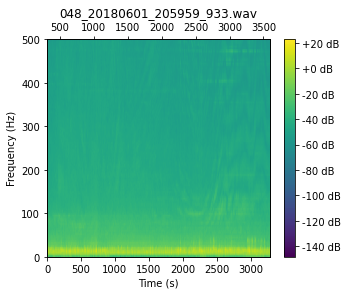

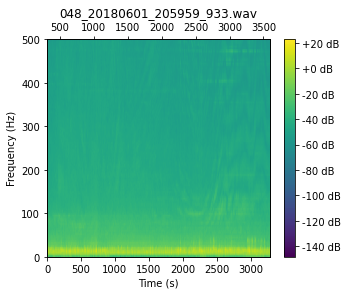

In [101]:
# compute the spectrogram of the 1st upcall, using the spectrogram parameters loaded from the saved model
spec1 = MagSpectrogram.from_wav(
    path=os.path.join(sound_files_path, '048_20180601_205959_933.wav'),
    offset=309.173, #- 0.5*spec_config['duration'],
    **spec_config)

spec1.plot() #create the figure
plt.show()  #display it

We explore a little bit different possible audio representations

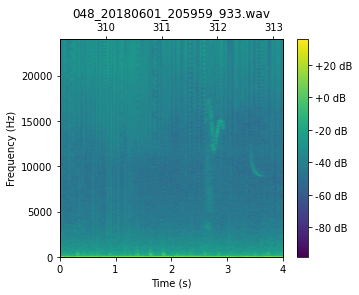

In [30]:
#shorter window, second stereo channel 
spec_config = {
    'channel': 1, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#      'rate': 1000, #None = use original rate
     'window': 0.1,
     'step': 0.032,
     'freq_min': 0,
     'freq_max': 25000,
     'window_func': 'hamming',
     'duration': 4
    }

spec2 = MagSpectrogram.from_wav(
    path=os.path.join(sound_files_path, '048_20180601_205959_933.wav'),
    offset=309.173, #- 0.5*spec_config['duration'],
    **spec_config)
spec2.plot()
plt.show()

0.05


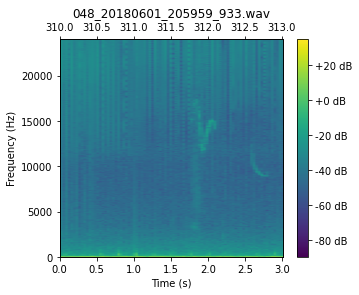

In [40]:
# 0.032
param = 0.050

for i in range(1):
    print(param)
    spec_config = {
        'channel': 1, #stereo channel (0 by default)
        'type': 'MagSpectrogram',
#          'rate': 100000, #None = use original rate
         'window': 0.085,
         'step': 0.035,
         'freq_min': 0,
         'freq_max': 25000,
         'window_func': 'hamming',
         'duration': 3
        }

    spec2 = MagSpectrogram.from_wav(
        path=os.path.join(sound_files_path, '048_20180601_205959_933.wav'),
        offset=310, #- 0.5*spec_config['duration'],
        **spec_config)
    spec2.plot()
    plt.show()
#     param = param - 0.002



<a id=section8></a>

<a id=section8></a> 
## 8. Creating the database

Now we have to compute the spectrograms following the settings above for each selection in our selection tables and then save them in a database.

All of this can be done with the ```dbi.create_database``` function in Ketos.

We will start with the training dataset. We need to indicate the name for the database we want to create, where the audio files are, a name for the dataset, the selections table and, finally the audio representation. As specified in our ``spec_cfg``, this is a Magnitude spectrogram, but ketos can also create databases with Power, Mel and CQT spectrograms, as well as time-domain data (waveforms).


In [340]:
spec_config = {
#     'channel': 1, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#      'rate': 1000, #None = use original rate
     'window': 0.0.85,
     'step': 0.035,
     'freq_min': 0,
     'freq_max': 25000,
     'window_func': 'hamming',
     'duration': 3
    }
#channel arg is shared with create_database method, that's why we move it there:
dbi.create_database(output_file='database_01.h5', 
                    channel = 1,
                    data_dir='data/train',
                    dataset_name='train',
                    selections=selections_train,
                    audio_repres=spec_config
                   )                             

100%|██████████| 1086/1086 [02:07<00:00,  8.49it/s]


1086 items saved to database_01.h5


And we do the same thing for the test set. Note that, by specifying the same database name, we are telling ketos that we want to add the test set to the existing database.

In [341]:
# channel arg is also added there in the same way as previously
dbi.create_database(output_file='database_01.h5', 
                    channel = 1,
                    data_dir='data/test',
                    dataset_name='test',
                    selections=selections_test,
                    audio_repres=spec_config
                   )                            

100%|██████████| 382/382 [00:44<00:00,  8.59it/s]

382 items saved to database_01.h5


Now we have our database with spectrograms representing audio segments with and without the North Atlantic Right Whale upcall. The data is divided into 'train' and 'test'. 



In [346]:
db = dbi.open_file("database_01.h5", 'r')

In [347]:
db

File(filename=database_01.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/test (Group) ''
/test/data (Table(382,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(125, 2401), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1,)
/train (Group) ''
/train/data (Table(1086,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(125, 2401), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1

Here we can see the data divided into 'train' and 'test' These are called 'groups' in HDF5 terms. Within each of them there's a dataset called 'data', which contains the spectrograms and respective labels.

In [344]:
db.close() #close the database connection

You will likely not need to directly interact with the database. In a following tutorial, we will use Ketos to build a deep neural network and train it to recognize upcalls. Ketos handles the database interactions, so we won't really have to go into the details of it, but if you would like to learn more about how to get data from this database, take a look at the [database_interface](https://docs.meridian.cs.dal.ca/ketos/modules/data_handling/database_interface.html) module in ketos and the [pyTables](https://www.pytables.org/index.html) documentation.